## Experiment No: 3
## Project: Diabetic Retinopathy
## Author: Shubham Kumar Singh
## Date: 17/10/2021
   
### Problem Statement: Classify Diabetic Retinopathy from diagnostic images
### Dataset: APTOS Blindness Detection Challenge
### Hypothesis: Create Ensembles of resnets and densenets using resnets as pretrained feature extractors
### Model: Ensemble of Resnet152 and Densenet121
### Training: 10 Epochs with SGD and CrossEntropyLoss
### Evaluation: Accuracy and Quadratic Kappa

### Data Preparation:

In [1]:
path = "/home/hexart/dataset/aptos2019-blindness-detection/"

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
df = pd.read_csv(os.path.join(path,"train.csv"))

In [4]:
df.describe()

,diagnosis
count,3662.000000
mean,1.126980
std,1.298409
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,4.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [6]:
df.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [7]:
def get_sample(dataset:str) -> np.ndarray:
    """
    This function will sample unbalanced dr_dataset into a balanced dr_dataset
    ***FOR DIABETIC RETINPATHY ONLY***
    :param dataset: csv file of the dr_dataset
    :return: numpy array containing shuffled balanced data samples
    """

    df_data = pd.read_csv(dataset)
    df_data_classes = dict.fromkeys(pd.unique(df_data.diagnosis))
    for i in pd.unique(df_data.diagnosis):
        df_data_classes[i] = df_data[df_data.diagnosis == i]


    n = np.min((df_data_classes[0].shape[0],
                df_data_classes[1].shape[0],
                df_data_classes[2].shape[0],
                df_data_classes[3].shape[0],
                df_data_classes[4].shape[0],))

    n = int(n - (n//4))

    rng = np.random.default_rng()
    train_samples = np.concatenate((rng.permutation(df_data_classes[0])[:n],
                                   rng.permutation(df_data_classes[1])[:n],
                                   rng.permutation(df_data_classes[2])[:n],
                                   rng.permutation(df_data_classes[3])[:n],
                                   rng.permutation(df_data_classes[4])[:n],))

    random_training_samples = rng.permutation(train_samples)

    return random_training_samples

In [8]:
data = get_sample(os.path.join(path,"train.csv"))

In [9]:
data.shape

(725, 2)

In [10]:
training_set = data[:int(len(data)*0.8)]
testing_set = data[int(len(data) * 0.8):]

In [11]:
import torch
torch.cuda.is_available()

True

In [12]:
image_dataset = dict.fromkeys(['train','val'])

In [13]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class dr_dataset(Dataset):

    def __init__(self, numpy_array, data_dir, transform=None, target_transform=None, ext=".png"):
        self.img_labels = pd.DataFrame(numpy_array)
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.ext = ext



    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, item):
        img_path = os.path.join(self.data_dir,self.img_labels.iloc[item,0]+self.ext)
        img = Image.open(img_path)
        label = self.img_labels.iloc[item,1]
        if self.transform:
            img = self.transform(img)
        else:
            self.transform = transforms.Compose([
                transforms.Resize(255),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225]),
            ])
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)

        return (img, label,)

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [15]:
image_dataset['train'] = dr_dataset(numpy_array=training_set,
                                     data_dir=os.path.join(path,'train_images'),
                                     transform = data_transforms['train'])
image_dataset['val'] = dr_dataset(numpy_array=testing_set,
                                     data_dir=os.path.join(path,'train_images'),
                                     transform = data_transforms['val'])

In [16]:
from torch.utils.data import DataLoader

dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x],
                                              batch_size=12,
                                              shuffle=True,
                                              num_workers=2)
               for x in ['train','val']}

In [17]:
dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'val']}


class_names = {
    0 : "No DR",
    1 : "NPDR Mild",
    2 : "NPDR Moderate",
    3 : "NPDR Severe",
    4 : "PDR"
}


### Model Building:

In [18]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import time
from sklearn.metrics import cohen_kappa_score


device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [19]:
model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 5)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma=0.1)

### Training & Testing:

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    metrics = []
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        predictions = []
        ground_truth = []

        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                predictions.extend(preds.cpu().detach().numpy())
                ground_truth.extend(labels.cpu().detach().numpy())

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_kappa = cohen_kappa_score(predictions, ground_truth)
            print('{} Loss:\t{:.4f}\tAcc:\t{:.4f}\tKappa:\t{:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_kappa))
            if phase == 'train':
                metrics.append([epoch,
                                epoch_loss,
                                np.double(epoch_acc.cpu().detach().numpy()),
                                epoch_kappa])
            else:
                metrics[epoch].extend([epoch_loss,
                                       np.double(epoch_acc.cpu().detach().numpy()),
                                       epoch_kappa])
                

    time_elapsed = time.time() - since
    print("Training Completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

    return (model,metrics,predictions, ground_truth)

In [21]:
model, metrics, predictions, ground_truth = train_model(model_ft,criterion,
                                                        optimizer_ft,
                                                        exp_lr_scheduler,
                                                        num_epochs=15)


Epoch 0/14
----------
train Loss:	1.5065	Acc:	0.3483	Kappa:	0.1849
val Loss:	1.3401	Acc:	0.3931	Kappa:	0.1966

Epoch 1/14
----------
train Loss:	1.2210	Acc:	0.4931	Kappa:	0.3656
val Loss:	1.1475	Acc:	0.4690	Kappa:	0.3603

Epoch 2/14
----------
train Loss:	1.1522	Acc:	0.5379	Kappa:	0.4217
val Loss:	1.1008	Acc:	0.5241	Kappa:	0.4190

Epoch 3/14
----------
train Loss:	1.0699	Acc:	0.5448	Kappa:	0.4308
val Loss:	1.1383	Acc:	0.5103	Kappa:	0.4224

Epoch 4/14
----------
train Loss:	1.0105	Acc:	0.5672	Kappa:	0.4588
val Loss:	1.1350	Acc:	0.5517	Kappa:	0.4552

Epoch 5/14
----------
train Loss:	1.0022	Acc:	0.5845	Kappa:	0.4804
val Loss:	1.0433	Acc:	0.5655	Kappa:	0.4759

Epoch 6/14
----------
train Loss:	0.9790	Acc:	0.5983	Kappa:	0.4976
val Loss:	1.1009	Acc:	0.5793	Kappa:	0.4931

Epoch 7/14
----------
train Loss:	0.8533	Acc:	0.6500	Kappa:	0.5624
val Loss:	0.9358	Acc:	0.6069	Kappa:	0.5517

Epoch 8/14
----------
train Loss:	0.8299	Acc:	0.6862	Kappa:	0.6074
val Loss:	0.9355	Acc:	0.6345	Kappa:	0.5948



### Evaluation:

In [22]:
import matplotlib.pyplot as plt

In [29]:
df = pd.DataFrame(metrics, columns=['epoch','t_loss','t_acc','t_kappa','v_loss','v_acc','v_kappa',])

In [30]:
df.head()

,epoch,t_loss,t_acc,t_kappa,v_loss,v_acc,v_kappa
0,0,1.506544,0.348276,0.184933,1.340142,0.393103,0.196552
1,1,1.220967,0.493103,0.365583,1.147474,0.468966,0.360345
2,2,1.152233,0.537931,0.421685,1.100827,0.524138,0.418966
3,3,1.069944,0.544828,0.430834,1.138309,0.510345,0.422414
4,4,1.010527,0.567241,0.458804,1.135013,0.551724,0.455172


In [31]:
df.describe()

,epoch,t_loss,t_acc,t_kappa,v_loss,v_acc,v_kappa
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,7.000000,0.949062,0.614713,0.518082,1.034251,0.571034,0.507471
std,4.472136,0.218841,0.104311,0.130492,0.122533,0.070582,0.121686
min,0.000000,0.745726,0.348276,0.184933,0.930169,0.393103,0.196552
25%,3.500000,0.778646,0.556034,0.444819,0.935658,0.537931,0.438793
50%,7.000000,0.853327,0.650000,0.562402,0.952962,0.606897,0.551724
75%,10.500000,1.040235,0.698276,0.622590,1.117932,0.624138,0.604310
max,14.000000,1.506544,0.715517,0.644225,1.340142,0.634483,0.624138


In [32]:
results = "/home/hexart/hexart/Hexart_Research_Cohort_2/Diabetic_Retinopathy/results"
df.to_csv(os.path.join(results,"dr_exp_{}_{}.csv".format(3,'ensemble')))

In [33]:
plots = "/home/hexart/hexart/Hexart_Research_Cohort_2/Diabetic_Retinopathy/plots"

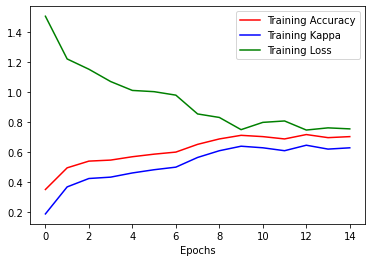

In [34]:
plt.plot(df.epoch,df.t_acc,'r',label="Training Accuracy")
plt.plot(df.epoch,df.t_kappa,'b',label="Training Kappa")
plt.plot(df.epoch,df.t_loss,'g',label="Training Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(plots,"dr_densenet121_pretrained_e{}_{}".format(15,'train')))

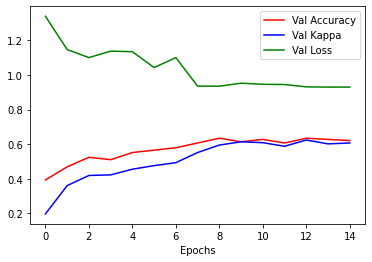

In [35]:
plt.plot(df.epoch,df.v_acc,'r',label="Val Accuracy")
plt.plot(df.epoch,df.v_kappa,'b',label="Val Kappa")
plt.plot(df.epoch,df.v_loss,'g',label="Val Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(plots,"dr_densenet121_pretrained_e{}_{}".format(15,'Val')))

In [37]:
Final_Kappa = cohen_kappa_score(predictions, ground_truth)

In [38]:
print(Final_Kappa)

0.6068965517241379
